<a href="https://colab.research.google.com/github/carlomagnani/Curso2020-2021-ODKG/blob/master/SP500_Trend_Forecast_morandi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

print("Tensorflow version: "+tf.__version__)

#! pip install pmdarima

# Google file system
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

drive.mount('/GoogleDrive', force_remount=True)

import math

file =   "/GoogleDrive/My Drive/S&P.xlsx"
dataset = pd.read_excel(file, sheet_name="ts")

Tensorflow version: 2.8.0
Mounted at /GoogleDrive


In [2]:
dataset['log_value'] = np.log(dataset['time'])
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['log_ret'] = dataset['log_value'] - dataset['log_value'].shift(+1)
dataset['sq_ret'] = np.power(dataset['log_ret'],2)
dataset['lead_ret'] = dataset['log_ret'].shift(-1)
dataset['lead_weekly_ret'] = dataset['log_ret'].rolling(5).sum().shift(-5)
dataset['lag_weekly_ret'] = dataset['log_ret'].rolling(5).sum()
dataset['sma_3'] = dataset['log_value'].rolling(3).mean()
dataset['sma_5'] = dataset['log_value'].rolling(5).mean()
dataset['sma_10'] = dataset['log_value'].rolling(10).mean()
dataset['sma_20'] = dataset['log_value'].rolling(20).mean()
dataset['sma_50'] = dataset['log_value'].rolling(50).mean()
dataset['sma_100'] = dataset['log_value'].rolling(100).mean()
dataset['sma_200'] = dataset['log_value'].rolling(200).mean()
dataset['log_ret_class'] = np.where(dataset['log_ret']>0,1,0)
dataset['lag_weekly_ret_class'] = np.where(dataset['lag_weekly_ret']>0,1,0)
dataset['lead_weekly_ret_class'] = np.where(dataset['lead_weekly_ret']> 0, 1, 0)
dataset['lead_ret_class'] = np.where(dataset['lead_ret']> 0, 1, 0)
dataset['ewma_var'] = dataset['sq_ret'].ewm(alpha = 0.96).mean()


dataset['ema_200'] = dataset['log_value'].ewm(alpha = 0.01).mean()
dataset['ema_50'] = dataset['log_value'].ewm(alpha = 0.0392).mean()
dataset['ema_10'] = dataset['log_value'].ewm(alpha = 0.181).mean()
dataset['ema_3'] = dataset['log_value'].ewm(alpha = 0.5).mean()

dataset.pop('time')

#dataset.dropna(inplace = True)

0          17.66
1          17.76
2          17.72
3          17.55
4          17.66
          ...   
23657    4328.87
23658    4201.09
23659    4170.70
23660    4277.88
23661    4259.52
Name: time, Length: 23662, dtype: float64

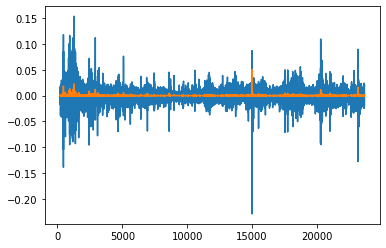

In [17]:
#plt.plot(dataset['log_value'])
#plt.plot(dataset['ma_3'])
#plt.plot(dataset['ma_20'])
plt.plot(dataset['log_ret'])
plt.plot(dataset['ewma_var'])

In [3]:
#Signal Generation

#Momentum Rule
dataset['momentum_120'] = dataset['log_value'] - dataset['log_value'].shift(+200)
dataset['momentum_121'] = dataset['log_value'].shift(+20) - dataset['log_value'].shift(+200)

dataset['mom_120_rule'] = np.where(dataset['momentum_120']> 0, 1, 0)
dataset['mom_121_rule'] = np.where(dataset['momentum_121']> 0, 1, 0)

#MA Change of Direction Rule

dataset['ma_200_cd_rule'] = np.where((dataset['sma_200']- dataset['sma_200'].shift(+1))>0,1,0)
dataset['ma_20_cd_rule'] = np.where((dataset['sma_20']- dataset['sma_20'].shift(+1))>0,1,0)

#PMA Rule

dataset['pma_20'] = dataset['log_value'] - dataset['sma_20']      
dataset['pma_100'] = dataset['log_value'] - dataset['sma_100']
dataset['pma_200'] = dataset['log_value'] - dataset['sma_200']

dataset['pma_20_rule'] = np.where(dataset['pma_20']>0, 1, 0)
dataset['pma_100_rule'] = np.where(dataset['pma_100']>0, 1, 0)
dataset['pma_200_rule'] = np.where(dataset['pma_200']>0, 1, 0)

#MA Crossover Rule

dataset['mac_3_10'] = dataset['sma_3'] - dataset['sma_10']
dataset['mac_50_200'] = dataset['sma_50'] - dataset['sma_200']

dataset['mac_3_10_rule'] = np.where(dataset['mac_3_10']>0, 1, 0)
dataset['mac_50_200_rule'] = np.where(dataset['mac_50_200']>0, 1, 0)

#Ma Convergence/Divergence Rule

dataset['mac_ema_50_200'] = dataset['ema_50'] - dataset['ema_200']

dataset['ema_mac_50_200'] = dataset['mac_ema_50_200'].ewm(alpha = 0.095).mean()

dataset['macd_50_200'] = dataset['mac_ema_50_200'] - dataset['ema_mac_50_200']

#plt.plot(dataset['macd_50_200'])

dataset['macd_50_200_rule'] = np.where(dataset['macd_50_200']>0, 1, 0)

In [4]:
rule_cols = [col for col in dataset.columns if 'rule' in col]

col_names = ['log_ret_class', 'lag_weekly_ret_class', 'ewma_var']

var_name = ['lead_weekly_ret_class']

col_names = var_name + col_names + rule_cols

#var_name = ['lead_weekly_ret_class']

print(col_names)

model_df = dataset[col_names]

model_df.dropna(inplace = True)

model_df


['lead_weekly_ret_class', 'log_ret_class', 'lag_weekly_ret_class', 'ewma_var', 'mom_120_rule', 'mom_121_rule', 'ma_200_cd_rule', 'ma_20_cd_rule', 'pma_20_rule', 'pma_100_rule', 'pma_200_rule', 'mac_3_10_rule', 'mac_50_200_rule', 'macd_50_200_rule']


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,lead_weekly_ret_class,log_ret_class,lag_weekly_ret_class,ewma_var,mom_120_rule,mom_121_rule,ma_200_cd_rule,ma_20_cd_rule,pma_20_rule,pma_100_rule,pma_200_rule,mac_3_10_rule,mac_50_200_rule,macd_50_200_rule
1,0,1,0,0.000032,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.000006,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0.000089,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0.000041,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0.000081,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23657,0,0,0,0.000063,1,1,1,0,0,0,0,1,1,0
23658,0,0,0,0.000864,1,1,1,0,0,0,0,0,1,0
23659,0,0,0,0.000085,1,1,1,0,0,0,0,0,1,0
23660,0,1,0,0.000621,1,1,1,0,0,0,0,0,1,0


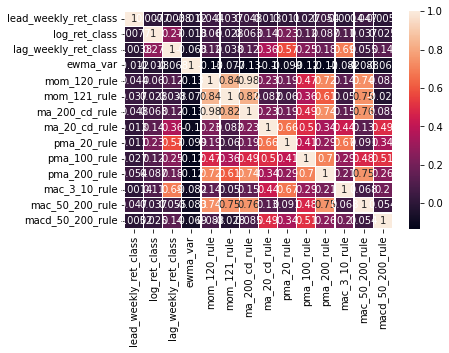

In [66]:
#Correlation Matrix

import seaborn as sn

corr_mat = model_df.corr()
sn.heatmap(corr_mat, annot=True, linewidths=.3)
plt.show()

In [5]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

#prepare Train-Test-Validate Dataset

steps = 100

values = model_df.values

# Creating a data structure with i time-steps and 1 output
X = []
y = []

for i in range(steps, len(values)):
    X.append(values[i-steps:i, 1:])
    y.append(values[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

y = np.reshape(y, (y.shape[0],1))

# Creating a data structure with i time-steps and 1 output
train_X = []
train_y = []

test_X = []
test_y = []

validation_X = []
validation_y = []

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

train_X, validation_X, train_y, validation_y = train_test_split(train_X, train_y, test_size=0.02, random_state=1) # 0.02 x 0.8 = 0.016

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, validation_X.shape, validation_y.shape)

(18471, 100, 13) (18471, 1) (4713, 100, 13) (4713, 1) (377, 100, 13) (377, 1)


In [7]:
train_y

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

Epoch 1/100
578/578 - 137s - loss: 0.6860 - accuracy: 0.5586 - val_loss: 0.6853 - val_accuracy: 0.5582 - 137s/epoch - 237ms/step
Epoch 2/100
578/578 - 130s - loss: 0.6845 - accuracy: 0.5641 - val_loss: 0.6850 - val_accuracy: 0.5599 - 130s/epoch - 225ms/step
Epoch 3/100
578/578 - 130s - loss: 0.6840 - accuracy: 0.5638 - val_loss: 0.6845 - val_accuracy: 0.5604 - 130s/epoch - 224ms/step
Epoch 4/100
578/578 - 129s - loss: 0.6834 - accuracy: 0.5666 - val_loss: 0.6840 - val_accuracy: 0.5625 - 129s/epoch - 224ms/step
Epoch 5/100
578/578 - 140s - loss: 0.6829 - accuracy: 0.5659 - val_loss: 0.6835 - val_accuracy: 0.5612 - 140s/epoch - 242ms/step
Epoch 6/100
578/578 - 171s - loss: 0.6822 - accuracy: 0.5668 - val_loss: 0.6841 - val_accuracy: 0.5606 - 171s/epoch - 296ms/step
Epoch 7/100
578/578 - 160s - loss: 0.6813 - accuracy: 0.5663 - val_loss: 0.6831 - val_accuracy: 0.5623 - 160s/epoch - 277ms/step
Epoch 8/100
578/578 - 133s - loss: 0.6802 - accuracy: 0.5712 - val_loss: 0.6841 - val_accuracy: 0

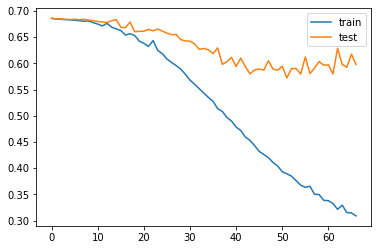

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience = 15, min_delta=0.001)

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history = model.fit(train_X, train_y, epochs = 100, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

yhat = (model.predict(validation_X) > 0.5).astype("int32")

yhat = yhat.reshape(yhat.shape[0],yhat.shape[1])

validation_y = validation_y.reshape(validation_y.shape[0],1)

print(confusion_matrix(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0]))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(pd.DataFrame(validation_y).iloc[:,0], pd.DataFrame(yhat).iloc[:,0], target_names = ['0', '1']))

#print(yhat, validation_y)

[[106  46]
 [ 44 181]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.70       152
           1       0.80      0.80      0.80       225

    accuracy                           0.76       377
   macro avg       0.75      0.75      0.75       377
weighted avg       0.76      0.76      0.76       377



In [11]:
#Import Random Forest and Train_Test Split
from sklearn.ensemble import RandomForestClassifier

train_rf_X = train_X[:,0,1:]

test_rf_X = test_X[:,0,1:]

train_rf_y = train_X[:,0,0]

test_rf_y = test_X[:,0,0]

#validation_rf_X = validation_X[:,0,1:]

#validation_rf_y = validation_y[:,0,0]

print(train_rf_X.shape, train_rf_y.shape, test_rf_X.shape, test_rf_y.shape)

#, test_rf_X, train_rf_y, test_rf_y = 

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_rf_X,train_rf_y)

y_pred = clf.predict(test_rf_X)

y_val = clf.predict(validation_rf_X)

from sklearn import metrics

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0], target_names = ['0', '1']))

#validation metrics
#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))


(18471, 12) (18471,) (4713, 12) (4713,)
[[1142 1098]
 [ 846 1627]]
              precision    recall  f1-score   support

           0       0.57      0.51      0.54      2240
           1       0.60      0.66      0.63      2473

    accuracy                           0.59      4713
   macro avg       0.59      0.58      0.58      4713
weighted avg       0.59      0.59      0.59      4713



In [12]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)

clf_gb.fit(train_rf_X,train_rf_y)

y_pred = clf_gb.predict(test_rf_X)

#y_val = clf_gb.predict(validation_rf_X)

#test metrics

print(confusion_matrix(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0]))

print(classification_report(pd.DataFrame(test_rf_y).iloc[:,0], pd.DataFrame(y_pred).iloc[:,0], target_names = ['0', '1']))

#validation metrics

#print(confusion_matrix(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0]))

#print(classification_report(pd.DataFrame(validation_rf_y).iloc[:,0], pd.DataFrame(y_val).iloc[:,0], target_names = ['0', '1']))




[[1311  929]
 [ 674 1799]]
              precision    recall  f1-score   support

           0       0.66      0.59      0.62      2240
           1       0.66      0.73      0.69      2473

    accuracy                           0.66      4713
   macro avg       0.66      0.66      0.66      4713
weighted avg       0.66      0.66      0.66      4713



In [84]:

#dataset[['lead_weekly_ret_class', 'lead_weekly_ret', 'lag_weekly_ret_class', 'lag_weekly_ret', 'log_ret' ]]
dataset[['lead_weekly_ret', 'log_ret', 'lead_ret' ]].head(12)




,lead_weekly_ret,log_ret,lead_ret
0,-0.022204,NaN,0.005647
1,-0.021101,0.005647,-0.002255
2,-0.004569,-0.002255,-0.009640
3,-0.004540,-0.009640,0.006248
4,-0.012073,0.006248,-0.009101
5,-0.004038,-0.009101,-0.007456
6,-0.005201,-0.007456,-0.001152
7,-0.005165,-0.001152,0.006893
8,-0.005705,0.006893,0.006277
9,0.020041,0.006277,-0.016634


In [ ]:
from tensorflow.keras.datasets import mnist

model_mpl = Sequential()

model_mlp.add(Dense(100, return_sequences=True, input_shape=(train_rf_X.shape[0], train_rf_X.shape[1]), activation = 'relu'))
model.add(Dropout(0.3))

#Additional layers we researched and then didn't use due to poor performance
model_mlp.add(Dense(100, return_sequences=True, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(100, return_sequences=False, activation = 'relu'))
model_mlp.add(Dropout(0.3))

model_mlp.add(Dense(units = 1, activation = 'sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [tf.keras.metrics.Recall()])
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics = 'accuracy')
# fit network
history_mlp = model_mlp.fit(train_rf_X, train_rf_y, epochs = 100, batch_size=32, validation_data = (test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])

# plot history
plt.plot(history_mlp.history_mlp['loss'], label='train')
plt.plot(history_mlp.history_mlp['val_loss'], label='test')
plt.legend()
plt.show()